# Predict Apple Stock using LSTM

In [70]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. ETL

In [71]:
df = pd.read_csv('../data/appl_1980_2014.csv')
df.head()
len(df)

8465

In [72]:
df.Date = pd.to_datetime(df.Date)

In [73]:
df.Date.dt.year.unique()

array([2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004,
       2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993,
       1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982,
       1981, 1980])

In [74]:
#let's scope it to only 2010 to 2014 to reduce computation
cond = (df.Date.dt.year > 2009) & (df.Date.dt.year < 2014)
df = df[cond]

In [75]:
df = df.set_index('Date')

In [76]:
df.sort_index(ascending=True, inplace=True)

In [77]:
df.head(-10)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,123432400,29.22
2010-01-05,214.60,215.59,213.25,214.38,150476200,29.27
2010-01-06,214.38,215.23,210.75,210.97,138040000,28.81
2010-01-07,211.75,212.00,209.05,210.58,119282800,28.75
2010-01-08,210.30,212.00,209.06,211.98,111902700,28.94
...,...,...,...,...,...,...
2013-12-10,563.58,567.88,561.20,565.55,69567400,79.87
2013-12-11,567.00,570.97,559.69,561.36,89929700,79.27
2013-12-12,562.14,565.34,560.03,560.54,65572500,79.16


## 2. EDA: Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with `plt.autoscale(axis='x',tight=True)`.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

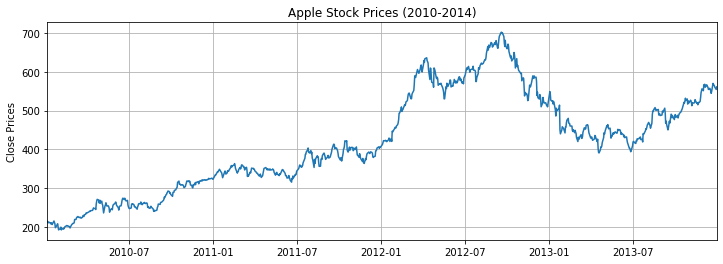

In [78]:
plt.figure(figsize=(12,4))
plt.title('Apple Stock Prices (2010-2014)')
plt.ylabel('Close Prices')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Close'])
plt.show()

## 3. Feature Extraction

In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [79]:
# Extract values from the source .csv file
y = df['Close'].values.astype(float)

# Define a test size
test_size = 15

# Create train and test sets
train_set = y[:-test_size]
test_set  = y[-test_size:]

In [80]:
test_set

array([565.55, 561.36, 560.54, 554.43, 557.5 , 554.99, 550.77, 544.46,
       549.02, 570.09, 567.67, 563.9 , 560.09, 554.52, 561.02])

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## 4. Preprocessing

### Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [81]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [82]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [83]:
train_norm.min()

-0.9999999999999999

In [84]:
train_norm.max()

1.0

In [85]:
train_norm.mean()

-0.12306197399969984

In [86]:
type(train_norm)

numpy.ndarray

### Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [87]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 30

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)

961

In [88]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9139, -0.9124, -0.9258, -0.9273, -0.9219, -0.9292, -0.9386, -0.9271,
         -0.9318, -0.9456, -0.9099, -0.9228, -0.9372, -0.9776, -0.9568, -0.9455,
         -0.9379, -0.9716, -1.0000, -0.9895, -0.9851, -0.9718, -1.0000, -0.9866,
         -0.9919, -0.9838, -0.9880, -0.9740, -0.9673, -0.9555]),
 tensor([-0.9588]))

## 5. Define the model
This time we'll use an LSTM layer of size (1,100).

In [89]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=50,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

### Instantiate the model, define loss and optimization functions

In [90]:
torch.manual_seed(9999)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [91]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   200
 10000
   200
   200
    50
     1
______
 10651


### Train the model

In [92]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    if epoch % 10 == 0:
        print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00894879
Epoch: 11 Loss: 0.00420683
Epoch: 21 Loss: 0.00333177
Epoch: 31 Loss: 0.00407441
Epoch: 41 Loss: 0.00286667
Epoch: 51 Loss: 0.00315007
Epoch: 61 Loss: 0.00383970
Epoch: 71 Loss: 0.00176836
Epoch: 81 Loss: 0.00227477
Epoch: 91 Loss: 0.00170818

Duration: 624 seconds


## 6. Run predictions and compare to known test set

In [93]:
# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(window_size):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [94]:
# Display predicted values
preds[-window_size:]    # equivalent to preds[-future:]

[0.49067822098731995,
 0.49780702590942383,
 0.5119304060935974,
 0.5304818153381348,
 0.5533931851387024,
 0.5811129212379456,
 0.6149778962135315,
 0.6565960645675659,
 0.7076195478439331,
 0.7694408893585205,
 0.8419846296310425,
 0.9179588556289673,
 0.9785043001174927,
 1.003296971321106,
 0.9903753995895386,
 0.9418329000473022,
 0.8636660575866699,
 0.7676870226860046,
 0.6646732091903687,
 0.5611786842346191,
 0.4589924216270447,
 0.3580727279186249,
 0.2517089247703552,
 0.12882208824157715,
 0.022926054894924164,
 -0.043966375291347504,
 -0.07720848172903061,
 -0.08652184158563614,
 -0.08028160780668259,
 -0.06506527960300446]

### Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [95]:
true_predictions = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1, 1))
true_predictions

array([[572.21021331],
       [574.02823678],
       [577.63005181],
       [582.36112496],
       [588.20409704],
       [595.27332274],
       [603.90973798],
       [614.52341137],
       [627.53567519],
       [643.30166281],
       [661.80213017],
       [681.17745716],
       [696.61805914],
       [702.94081011],
       [699.64548628],
       [687.26593533],
       [667.33143634],
       [642.85438296],
       [616.58328517],
       [590.18959395],
       [564.12954233],
       [538.39249744],
       [511.26706854],
       [479.92785305],
       [452.92171715],
       [435.86247514],
       [427.38490695],
       [425.00976735],
       [426.60118297],
       [430.48172707]])

In [96]:
df['Close'][-15:]

Date
2013-12-10    565.55
2013-12-11    561.36
2013-12-12    560.54
2013-12-13    554.43
2013-12-16    557.50
2013-12-17    554.99
2013-12-18    550.77
2013-12-19    544.46
2013-12-20    549.02
2013-12-23    570.09
2013-12-24    567.67
2013-12-26    563.90
2013-12-27    560.09
2013-12-30    554.52
2013-12-31    561.02
Name: Close, dtype: float64

### Plot the results
For plotting, we simply use the index of the original dataset.

In [97]:
df['Close'][-15:].index

DatetimeIndex(['2013-12-10', '2013-12-11', '2013-12-12', '2013-12-13',
               '2013-12-16', '2013-12-17', '2013-12-18', '2013-12-19',
               '2013-12-20', '2013-12-23', '2013-12-24', '2013-12-26',
               '2013-12-27', '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [98]:
x = df['Close'][-window_size:].index

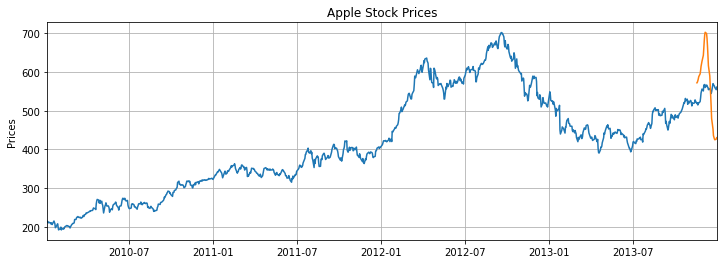

In [99]:
plt.figure(figsize=(12,4))
plt.title('Apple Stock Prices')
plt.ylabel('Prices')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Close'])
plt.plot(x,true_predictions)
plt.show()

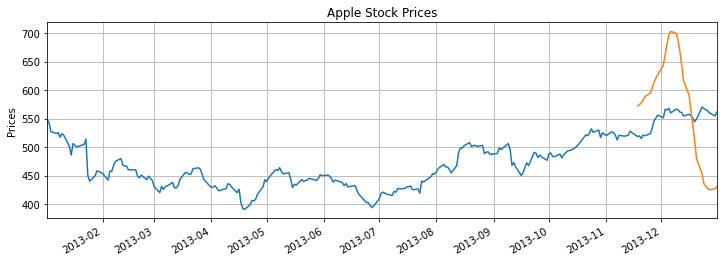

In [100]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Apple Stock Prices')
plt.ylabel('Prices')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['Close']['2013-01-01':])
plt.plot(x,true_predictions)
plt.show()